In [1]:
# p2
!pwd

/opt/ext/home/soroush/csp-nn/notebooks


In [2]:
!pip install nb-black
!pip install hyperopt


[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
%config Completer.use_jedi = False
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
import sys

sys.path.insert(0, "../")

## Dataset

In [5]:
import os
from typing import Dict, List, Tuple, Any, Union, Callable
from torch import Tensor
import torch
import numpy as np
import scipy
from torch.utils.data import DataLoader
from pytorch_lightning.utilities.apply_func import apply_to_collection
from cspnn.data.bci.bci_dataset import BCI2aDataset
from cspnn.data.utils import eeg_electrode_configs

from functools import partial
import torch.optim as optim
from torch.utils.data import random_split

from hyperopt import tpe, hp, fmin

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [6]:
class ToTensor:
    def __init__(self, device):
        if isinstance(device, str):
            device = torch.device(device)
        self.device = device

    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.from_numpy(a),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: torch.tensor(a, dtype=torch.float64),
        )

        return data, label


class ToNumpy:
    def __call__(self, data, label):
        data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )
        label = apply_to_collection(
            label,
            dtype=(np.ndarray, int, float, np.int64),
            function=lambda a: a.cpu().detach().numpy(),
        )

        return data, label


class DictToTensor:
    def __call__(self, data: Dict[str, Tensor], label):
        # The output shape [batch, channel, signal]
        return (
            torch.permute(
                torch.vstack(list(map(lambda a: a.unsqueeze(0), data.values()))),
                (1, 0, 2),
            ),
            label,
        )


class DictToArray:
    def __call__(self, data, label):
        # The output shape [batch, channel, signal]
        return (
            np.transpose(
                np.vstack(
                    list(map(lambda a: np.expand_dims(a, axis=0), data.values()))
                ),
                (1, 0, 2),
            ),
            label,
        )


class Windowing:
    def __init__(self, n_segments: int = 5, sample_rate: float = 250.0):
        self.n_segments = n_segments
        self.sample_rate = sample_rate

    # The Output of the signal is [batch, channels, windowed, band_filtered, signal]
    def __call__(self, data: Tensor, label):
        """Takes as input a signal tensor of shape [batch, channels, band_filtered, signal]
        and outputs a signal tensor of shape [batch, channels, windowed, band_filtered, signal]
        """
        start, end = 0, data.size()[-1]
        step = int((end - start) / self.n_segments)
        windows = np.arange(start, end - step, step=step)

        if len(windows) == 0:
            data = data.unsqueeze(dim=2)
            return data, label

        windowed_data = torch.permute(
            torch.stack(
                [data[:, :, :, window : (window + step)] for window in windows], dim=0
            ),
            (1, 2, 0, 3, 4),
        )

        return windowed_data, label


class Filtering:
    def __init__(self, N: int, rs: float, Wns: List[float], bandwidth, fs: float):
        self.N = N
        self.rs = rs
        self.Wns = Wns / (fs / 2)  # Normalize the signals
        self.bandwidth = bandwidth / (fs / 2)  # Normalize the signals
        self.fs = fs

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = []

        for wn in self.Wns:
            b, a = scipy.signal.cheby2(
                N=self.N,
                rs=self.rs,
                Wn=[wn, wn + self.bandwidth],
                btype="bandpass",
                fs=self.fs,
            )
            filtered_data.append(scipy.signal.filtfilt(b, a, data, axis=-1))

        filtered_data = torch.permute(torch.Tensor(filtered_data), (1, 2, 0, 3))

        return filtered_data, label


class ExpandDim(object):
    def __init__(self, dim):
        self.dim = dim

    def __call__(self, data, label):
        return data.unsqueeze_(self.dim), label


class LabelToDict:
    def __call__(self, data, label):
        return data, {"label": label}


class ToNumpy:
    def __call__(self, data, label):
        return data.cpu().detach().numpy(), label.cpu().detach().numpy()


class Compose:
    def __init__(self, transforms: List[Callable]) -> None:
        self.transforms = transforms

    def __call__(self, data: Any, target: Any):
        for t in self.transforms:
            data, target = t(data, target)
        return data, target

    def __repr__(self):
        return "\n".join([c.__class__.__name__ for c in self.transforms])


# TODO: complete this part
from scipy.signal import cheby2, filtfilt


def cheby_bandpass_filter(signal, attenuation, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = cheby2(order, rs=attenuation, Wn=[low, high], btype="band")
    y = filtfilt(b, a, signal, axis=-1)
    # print("filtered shape ", y.shape)
    return y


def cheby_bandpass_one_subject(
    X, attenuation, lowcut, highcut, fs, interval=None, verbose=True
):
    temp_epoch_EEG = X.copy()
    # print(f"data shape : {temp_epoch_EEG.shape}")

    if interval is not None:
        startband = np.arange(lowcut, highcut, step=interval)

        bands = []
        for start in startband:
            # This will be new key inside the EEG_filtered
            band = "{:02d}_{:02d}".format(start, start + interval)

            if verbose:
                print("Filtering through {} Hz band".format(band))
            # Bandpass filtering
            bands.append(
                cheby_bandpass_filter(
                    temp_epoch_EEG, attenuation, start, start + interval, fs
                )
            )

        return np.vstack(bands)

    else:
        # This will be new key inside the EEG_filtered
        band = "{:02d}_{:02d}".format(lowcut, highcut)

        return cheby_bandpass_filter(temp_epoch_EEG, attenuation, lowcut, highcut, fs)


from functools import partial


class BandPass:
    def __init__(self, attenuation, lowcut, highcut, fs, interval=None):
        self.attenuation = attenuation
        self.lowcut = lowcut
        self.highcut = highcut
        self.fs = fs
        self.interval = interval

        self.bandpass_func = partial(
            cheby_bandpass_one_subject,
            attenuation=self.attenuation,
            lowcut=self.lowcut,
            highcut=self.highcut,
            fs=self.fs,
            interval=self.interval,
            verbose=False,
        )

    # The Output of the signal is [batch, channels, band_filtered, signal]
    def __call__(self, data, label):
        filtered_data = data = apply_to_collection(
            data,
            dtype=(np.ndarray, int, float, np.int64, Tensor),
            function=self.bandpass_func,
        )

        filtered_data = np.expand_dims(filtered_data.transpose(1, 0, 2), axis=0)

        return filtered_data, label


class Whitening:
    def __init__(self, data_loader, whitening_method="PCA"):
        self.ds = data_loader
        self.method = whitening_method

        self.W = self._generate_whitening_transformation(self.ds, self.method)

    def _generate_whitening_transformation(self, data_loader, whitening_method="PCA"):
        """extract whitening transformation from data

        Parameters
        ----------
        data_loader : torch.dataloader
            pytorch data loader
        whitening_method : str
            one of following values
            "PCA" for PCA whitening
            "ZCA for ZCA whitening

        Returns
        -------
        torch.Tensor
            whitening transformation matrix
        """
        # get data
        signal = []
        for sig, lbl in data_loader:
            signal.append(sig)
        signal = torch.vstack(signal)

        # zero center
        x = signal.squeeze()
        sig = x.permute(0, 2, 1)
        x = torch.mean(sig, axis=1)
        x_mean = torch.mean(x, axis=0)

        x = sig - x_mean
        x_zero_centered = x.permute(0, 2, 1)

        # Calculate whitening matrix
        x_cov = self._calc_cov(x_zero_centered)

        lda, V = torch.linalg.eig(x_cov)
        lda, V = lda.real, V.real
        if "PCA":
            whitening_mat = torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T
        elif "ZCA":
            whitening_mat = V @ torch.sqrt(torch.inverse(torch.diag(lda))) @ V.T

        return whitening_mat

    def _calc_cov(self, EEG_data):
        cov = []
        for i in range(EEG_data.size()[0]):
            cov.append(
                EEG_data[i] @ EEG_data[i].T / torch.trace(EEG_data[i] @ EEG_data[i].T)
            )

        cov = torch.mean(torch.stack(cov), 0)

        return cov

    def __call__(self, data: Tensor, label):
        whitened_data = self.W @ data
        return whitened_data, label

In [7]:
def collate_fn(batch):
    imgs = torch.vstack([item[0] for item in batch])

    trgts = {}
    sample_item_label = batch[0][1]
    for label_key in sample_item_label.keys():
        if isinstance(sample_item_label[label_key], dict):
            trgts[label_key] = {
                key: torch.vstack([item[1][label_key][key].squeeze() for item in batch])
                for key in sample_item_label[label_key].keys()
            }
        else:
            trgts[label_key] = torch.vstack(
                [item[1][label_key] for item in batch]
            ).squeeze()

    return [imgs, trgts]

In [8]:
directory = "../test_data"
electrod_positions, shape = eeg_electrode_configs(
    "../configs/eeg_recording_standard/international_10_20_22.py"
)
if not os.path.exists(directory):
    os.makedirs(directory)


fs = 250
low_freq = 4
high_freq = 38
bandwidth = 4
overlap = 2

freqs = np.arange(low_freq, high_freq - (bandwidth - overlap), overlap)

lowcut = 4
highcut = 40
fs = 250
attenuation = 40
interval = 4

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    # ToNumpy(),
    # BandPass(
    #     attenuation=attenuation,
    #     lowcut=lowcut,
    #     highcut=highcut,
    #     fs=fs,
    #     interval=interval,
    # ),
    # ToTensor(device="cpu"),
    # Filtering(N=4, rs=40, Wns=freqs, bandwidth=bandwidth, fs=fs),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    # Windowing(n_segments=1),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
    in_mem=True,  # patients=[2],
)

train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)
########################################################################
transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    Whitening(train_dataloader, whitening_method="ZCA"),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=1,
)

transforms = [
    ToTensor(device="cuda"),
    DictToTensor(),
    Whitening(train_dataloader, whitening_method="ZCA"),
    ExpandDim(dim=2),
    ExpandDim(dim=2),
    LabelToDict(),
]
compose = Compose(transforms=transforms)

ds = BCI2aDataset(
    eeg_electrode_positions=electrod_positions,
    data_path=directory,
    transforms=compose,
)

In [9]:
for i in range(len(ds)):
    wave, label = ds[i]
    print(wave.min(), wave.max())
    print(wave.shape)
    if np.isnan(wave).any() or np.isinf(wave).any():
        print(f"date {i} : has NAN or INF")
    break

tensor(-124.5944, dtype=torch.float64) tensor(147.9470, dtype=torch.float64)
torch.Size([1, 22, 1, 1, 1001])


In [10]:
batch_size = 16
train_dataset, val_dataset = ds.get_train_test_subsets()

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)


val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    num_workers=os.cpu_count(),
)

## Model

In [11]:
import torch
import numpy as np
import torch.nn as nn
from cspnn.csp_nn import CSP, CSPNN

In [12]:
import torch.optim as optim

In [13]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    accuracy_score,
    cohen_kappa_score,
)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim

# from tqdm import tqdm
from tqdm.notebook import tqdm
import random

In [14]:
class SeparableConv2D(nn.Module):
    """https://github.com/seungjunlee96/Depthwise-Separable-Convolution_Pytorch/blob/master/DepthwiseSeparableConvolution/DepthwiseSeparableConvolution.py"""

    def __init__(
        self,
        in_channels,
        out_channels,
        depth_multiplier=1,
        kernel_size=3,
        padding="valid",
        bias=False,
    ):
        super(SeparableConv2D, self).__init__()
        self.depthwise = DepthwiseConv2d(
            in_channels, depth_multiplier, kernel_size, padding=padding, bias=bias
        )
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out


class DepthwiseConv2d(nn.Conv2d):
    def __init__(
        self,
        in_channels,
        depth_multiplier=1,
        kernel_size=3,
        stride=1,
        padding=0,
        dilation=1,
        bias=True,
        padding_mode="zeros",
    ):
        out_channels = in_channels * depth_multiplier
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
            dilation=dilation,
            groups=in_channels,
            bias=bias,
            padding_mode=padding_mode,
        )


class EEGNetv2(nn.Module):
    """
    Note: Use this class carefully. It is specificaly adapted with BCI Comp. IV 2a
        (22 channels, sample rate of 250, 3 seconds). So it's not a general class.
        it is developed only for experiment purposes.
    Implemented based on keras/tensorflow implementation found here:
        https://github.com/vlawhern/arl-eegmodels
    Paper:
        https://iopscience.iop.org/article/10.1088/1741-2552/aace8c
    """

    def __init__(
        self,
        num_classes=4,
        channels=22,
        dropout_rate=0.5,
        kernel_length=64,
        F1=8,
        D=2,
        F2=16,
    ):
        super(EEGNetv2, self).__init__()
        self.dropout_rate = dropout_rate

        # Layer 1
        self.conv1 = nn.Conv2d(
            num_classes, F1, (1, kernel_length), padding="valid", bias=False
        )
        self.batchnorm1 = nn.BatchNorm2d(F1, False)
        self.dwconv2 = DepthwiseConv2d(
            in_channels=F1,
            depth_multiplier=D,
            kernel_size=(channels, 1),
            stride=1,
            padding="valid",
            bias=False,
        )

        self.batchnorm2 = nn.BatchNorm2d(2 * F1, False)
        # act elu
        self.pooling1 = nn.AvgPool2d((1, 4))
        # dropout

        # Layer 2
        self.sepconv2 = SeparableConv2D(2 * F1, F2, 1, (1, 16), padding="same")
        self.batchnorm3 = nn.BatchNorm2d(F2, False)
        # elu
        self.pooling2 = nn.AvgPool2d((1, 8))
        # dropout

        # FC Layer
        self.fc1 = nn.Linear(16 * 30, 4)

    def _forward_emb(self, x, device=None):
        # Layer 1
        # print(f"{x.size()}")
        x = self.conv1(x)
        # print(f"{x.size()}")
        x = self.batchnorm1(x)

        x = self.dwconv2(x)
        # print(f"{x.size()}")
        x = self.batchnorm2(x)
        x = F.elu(x)
        x = self.pooling1(x)
        if self.training:
            x = F.dropout(x, self.dropout_rate)

        x = self.sepconv2(x)
        # print(f"{x.size()}")
        x = self.batchnorm3(x)
        x = F.elu(x)
        x = x.squeeze()
        x = self.pooling2(x)
        # print(f"{x.size()}")
        if self.training:
            x = F.dropout(x, self.dropout_rate)

        # FC Layer
        x = x.reshape((-1, 16 * 30))
        return x

    def forward(self, x, device=None):
        x = self._forward_emb(x)
        x = F.softmax(self.fc1(x), dim=1)
        return x


class CSPNNCls(nn.Module):
    def __init__(
        self,
        num_channels: int,
        num_features: int = None,
        num_bands: int = None,
        num_windows: int = 1,
        num_labels: int = None,
        csp_pow: bool = True,
        signal_len: int = None,
        mode: str = "constant",
        dropout_rate=0.5,
    ):
        super(CSPNNCls, self).__init__()
        self.num_channels = num_channels
        self.num_features = num_channels if num_features is None else num_features
        self.num_bands = num_bands
        self.num_windows = num_windows
        self.num_labels = num_labels
        self.csp_pow = csp_pow
        if not self.csp_pow:
            self.signal_len = signal_len
        self.mode = mode

        self.conv1 = CSPNN(
            num_channels=num_channels,
            num_features=num_features,
            num_bands=num_bands,
            num_windows=num_windows,
            num_labels=num_labels,
            csp_pow=csp_pow,
            mode=self.mode,
        )

        if self.csp_pow:
            csp_feature_size = (
                self.num_bands * self.num_windows * self.num_labels * self.num_features
            )
        else:
            csp_feature_size = (
                self.num_bands
                * self.num_windows
                * self.num_labels
                * self.num_features
                * 51
            )

        self.eegnet = EEGNetv2(
            num_classes=4,
            channels=22,
            dropout_rate=dropout_rate,
            kernel_length=32,
            F1=8,
            D=2,
            F2=16,
        )

    def forward(self, x):
        csp = self.conv1(x)

        # features = csp.reshape(
        #     (csp.size()[0] * csp.size()[1], self.num_channels, -1)  # batch * labels
        # )

        features = csp.reshape(
            (csp.size()[0], self.num_channels, csp.size()[1], -1)  # batch * labels
        )
        features = features.permute(0, 2, 1, 3)

        x = self.eegnet(features)

        if self.training:
            return x, csp
        return x, csp


net = CSPNNCls(
    num_channels=22,
    num_features=22,
    num_bands=1,
    num_windows=1,
    num_labels=4,
    csp_pow=False,
    signal_len=1001,
    mode="csp",
)
# .cuda(0)
cls_criterion = nn.CrossEntropyLoss()  # nn.BCELoss()
# reg_criterion = nn.MSELoss()
net = net.to("cuda")
# optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=0.00)
optimizer = optim.SGD(
    net.parameters(), lr=0.01, momentum=0.9, nesterov=True, weight_decay=0
)

# optimizer = optim.SGD(
#     [
#         {"params": net.conv1.parameters()},
#         {"params": net.fc2.parameters(), "weight_decay": 5e-3},
#         # {"params": net.fc1.parameters(), "weight_decay": 5e-3},
#         {"params": net.fc.parameters()},
#     ],
#     lr=0.001,
#     momentum=0.9,
#     nesterov=True,
#     weight_decay=0,
# )

# lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(
#     optimizer, max_lr=0.1, steps_per_epoch=1, epochs=200
# )
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [15]:
signals = torch.empty((10, 22, 1, 1, 1001), dtype=torch.float32).random_(1, 50)
signals = signals.to("cuda")
a, b = net(signals)
a.size(), b.size()

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:883.)
  return F.conv2d(input, weight, bias, self.stride,


(torch.Size([10, 4]), torch.Size([10, 4, 22, 1001]))

## hyperopt

In [16]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred, _ = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results


def fine_tune(config):
    net = CSPNNCls(
        num_channels=22,
        num_features=22,
        num_bands=1,
        num_windows=1,
        num_labels=4,
        csp_pow=False,
        signal_len=1001,
        mode="csp",
        dropout_rate=config["dropout_rate"],
    )

    device = "cpu"
    if torch.cuda.is_available():
        print("cuda")
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)

    net.to(device)
    cls_criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(),
        lr=config["lr"],
        momentum=0.9,
        nesterov=True,
        weight_decay=0,
    )

    train_dataset, val_dataset = ds.get_train_test_subsets()

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=os.cpu_count(),
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=int(config["batch_size"]),
        collate_fn=collate_fn,
        num_workers=os.cpu_count(),
    )

    history = {
        "train_loss": [],
        "test_loss": [],
        "train_acc": [],
        "test_acc": [],
        "train_kappa": [],
        "test_kappa": [],
        "train_fmeasure": [],
        "test_fmeasure": [],
        # "lr": [],
    }

    for epoch in tqdm(
        range(1000), position=0, desc="epoch"
    ):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        net.train()
        # for data in tqdm(train_dataloader, position=0, desc="mini batches"):
        for data in train_dataloader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs, csp_out = net(inputs.float().cuda(0))
            cls_loss = cls_criterion(
                outputs, labels["label"].type(torch.LongTensor).cuda(0)
            )
            loss = cls_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1

            # Validation accuracy
            # params = ["acc", "kappa", "auc", "fmeasure", "loss"]
            params = ["acc", "kappa", "fmeasure", "loss"]
            # print(params)
            # print("Training Loss ", running_loss / len(train_dataloader))
            tr = evaluate(net, train_dataloader, params)
            # print("Train - ", tr)
            ev = evaluate(net, val_dataloader, params)
            # print("Validation - ", ev)
            history["train_loss"].append(tr[-1])
            history["train_acc"].append(tr[0])
            history["train_kappa"].append(tr[1])
            history["train_fmeasure"].append(tr[2])

            history["test_loss"].append(ev[-1])
            history["test_acc"].append(ev[0])
            history["test_kappa"].append(ev[1])
            history["test_fmeasure"].append(ev[2])

            if epoch_steps % 2 == 0:
                break
    # history["lr"].append(config["lr"])
    df = pd.DataFrame.from_dict(history)
    df.to_csv(
        f"results/p2/history_dr{config['dropout_rate']}_lr{config['lr']}_bs{config['batch_size']}.csv"
    )

    return ev[-1].item()

In [38]:
config = {"dropout_rate": 0.6, "lr": 0.1, "batch_size": 16}
fine_tune(config)

0
[1,     1] loss: 1.385
0
[2,     1] loss: 1.376
Finished Training


tensor(1.3863)

In [ ]:
def main(max_evals=10):
    search_space = {
        "dropout_rate": hp.choice("dropout_rate", [0.1, 0.2, 0.3, 0.4, 0.5]),
        "lr": hp.choice("lr", [1e-4, 1e-3, 1e-2, 1e-1]),
        "batch_size": hp.choice("batch_size", [2, 4, 8, 16, 32]),
    }

    best = fmin(
        fn=fine_tune,  # Objective Function to optimize
        space=search_space,  # Hyperparameter's Search Space
        algo=tpe.suggest,  # Optimization algorithm (representative TPE)
        max_evals=max_evals,  # Number of optimization attempts
    )

    # print(best)
    # df = pd.DataFrame.from_dict(best, orient="index")
    # df.to_csv("results/results.csv")
    pass


main(max_evals=50)

  0%|                                                                      | 0/50 [00:00<?, ?trial/s, best loss=?]

epoch:   0%|          | 0/120 [00:00<?, ?it/s]

  2%|▊                                      | 1/50 [23:42<19:21:34, 1422.33s/trial, best loss: 1.3791327476501465]

epoch:   0%|          | 0/120 [00:00<?, ?it/s]

  4%|█▌                                     | 2/50 [36:30<13:49:47, 1037.25s/trial, best loss: 1.3688963651657104]

epoch:   0%|          | 0/120 [00:00<?, ?it/s]

  6%|██▍                                     | 3/50 [47:53<11:26:04, 875.84s/trial, best loss: 1.3688963651657104]

epoch:   0%|          | 0/120 [00:00<?, ?it/s]

  8%|███▏                                    | 4/50 [59:26<10:16:00, 803.50s/trial, best loss: 1.3688963651657104]

epoch:   0%|          | 0/120 [00:00<?, ?it/s]

 10%|███▋                                 | 5/50 [1:42:00<17:56:02, 1434.73s/trial, best loss: 1.3688963651657104]

epoch:   0%|          | 0/120 [00:00<?, ?it/s]

 12%|████▍                                | 6/50 [1:52:27<14:10:44, 1160.09s/trial, best loss: 1.3688963651657104]

epoch:   0%|          | 0/120 [00:00<?, ?it/s]

In [192]:
def find_best(folder_path, key):
    data = {
        "name": [],
        "train_loss": [],
        "test_loss": [],
        "train_acc": [],
        "test_acc": [],
        "train_kappa": [],
        "test_kappa": [],
        "train_fmeasure": [],
        "test_fmeasure": [],
    }

    for path in glob.glob(os.path.join(folder_path, "*.csv")):
        df = pd.read_csv(path)

        data["name"].append(os.path.split(path)[-1].replace(".csv", ""))
        data["train_loss"].append(list(df["train_loss"])[-1])
        data["test_loss"].append(list(df["test_loss"])[-1])
        data["train_acc"].append(list(df["train_acc"])[-1])
        data["test_acc"].append(list(df["test_acc"])[-1])
        data["train_kappa"].append(list(df["train_kappa"])[-1])
        data["test_kappa"].append(list(df["test_kappa"])[-1])
        data["train_fmeasure"].append(list(df["train_fmeasure"])[-1])
        data["test_fmeasure"].append(list(df["test_fmeasure"])[-1])

    df = pd.DataFrame.from_dict(data)
    df = df.sort_values(by=[key], ascending=False, ignore_index=True)
    print(df.head(1))

    params = list(df["name"])[0].split("_")
    best_config = {
        "dropout_rate": float(params[1].replace("dr", "")),
        "lr": float(params[2].replace("lr", "")),
        "batch_size": float(params[3].replace("bs", "")),
    }
    return best_config

In [193]:
find_best("results", key="test_acc")

                       name      train_loss       test_loss  train_acc  \
0  history_dr0.4_lr0.01_bs8  tensor(1.3862)  tensor(1.3863)   0.241898   

   test_acc  train_kappa  test_kappa  train_fmeasure  test_fmeasure  
0  0.255787    -0.010802    0.007716        0.241898       0.255787  


{'dropout_rate': 0.4, 'lr': 0.01, 'batch_size': 8.0}

In [ ]:
# !rm results/all_patients/*.csv
# !rm -r results/p2

In [13]:
# !mv results/*.csv results/all_patients

In [17]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred, _ = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results


def fine_tune(config):
    net = CSPNNCls(
        num_channels=22,
        num_features=22,
        num_bands=1,
        num_windows=1,
        num_labels=4,
        csp_pow=False,
        signal_len=1001,
        mode="csp",
        dropout_rate=config["dropout_rate"],
    )

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = nn.DataParallel(net)

    net.to(device)
    cls_criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        net.parameters(),
        lr=config["lr"],
        momentum=0.9,
        nesterov=True,
        weight_decay=0,
    )

    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

    train_dataset, val_dataset = ds.get_train_test_subsets()

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=os.cpu_count(),
    )

    val_dataloader = DataLoader(
        val_dataset,
        batch_size=int(config["batch_size"]),
        collate_fn=collate_fn,
        num_workers=os.cpu_count(),
    )

    history = {
        "train_loss": [],
        "test_loss": [],
        "train_acc": [],
        "test_acc": [],
        "train_kappa": [],
        "test_kappa": [],
        "train_fmeasure": [],
        "test_fmeasure": [],
        "lr": [],
    }

    for epoch in tqdm(
        range(1000), position=0, desc="epoch"
    ):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        net.train()
        # for data in tqdm(train_dataloader, position=0, desc="mini batches"):
        for data in tqdm(train_dataloader, position=0, desc="data_loader"):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs, csp_out = net(inputs.float().cuda(0))
            cls_loss = cls_criterion(
                outputs, labels["label"].type(torch.LongTensor).cuda(0)
            )
            loss = cls_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            epoch_steps += 1

        history["lr"].append(optimizer.param_groups[0]["lr"])
        # print(optimizer.param_groups[0]["lr"])
        lr_scheduler.step()

        # Validation accuracy
        # params = ["acc", "kappa", "auc", "fmeasure", "loss"]
        params = ["acc", "kappa", "fmeasure", "loss"]
        # print(params)
        # print("Training Loss ", running_loss / len(train_dataloader))
        tr = evaluate(net, train_dataloader, params)
        # print("Train - ", tr)
        ev = evaluate(net, val_dataloader, params)
        # print("Validation - ", ev)
        history["train_loss"].append(tr[-1])
        history["train_acc"].append(tr[0])
        history["train_kappa"].append(tr[1])
        history["train_fmeasure"].append(tr[2])

        history["test_loss"].append(ev[-1])
        history["test_acc"].append(ev[0])
        history["test_kappa"].append(ev[1])
        history["test_fmeasure"].append(ev[2])

    df = pd.DataFrame.from_dict(history)
    df.to_csv(
        f"results/all_patient_dr{config['dropout_rate']}_lr{config['lr']}_bs{config['batch_size']}.csv"
    )

    return history

In [20]:
config = {"dropout_rate": 0.4, "lr": 0.1, "batch_size": 32}
history = fine_tune(config)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

data_loader:   0%|          | 0/81 [00:00<?, ?it/s]

data_loader:   0%|          | 0/81 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Train Loop

In [17]:
net = net.cuda()
# net = net.to("cuda")
net

CSPNNCls(
  (conv1): CSPNN(
    (cspw): ModuleDict(
      (label-1_band-0_window-0): CSP()
      (label-2_band-0_window-0): CSP()
      (label-3_band-0_window-0): CSP()
      (label-4_band-0_window-0): CSP()
    )
  )
  (eegnet): EEGNetv2(
    (conv1): Conv2d(4, 8, kernel_size=(1, 32), stride=(1, 1), padding=valid, bias=False)
    (batchnorm1): BatchNorm2d(8, eps=False, momentum=0.1, affine=True, track_running_stats=True)
    (dwconv2): DepthwiseConv2d(8, 16, kernel_size=(22, 1), stride=(1, 1), padding=valid, groups=8, bias=False)
    (batchnorm2): BatchNorm2d(16, eps=False, momentum=0.1, affine=True, track_running_stats=True)
    (pooling1): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (sepconv2): SeparableConv2D(
      (depthwise): DepthwiseConv2d(16, 16, kernel_size=(1, 16), stride=(1, 1), padding=same, groups=16, bias=False)
      (pointwise): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (batchnorm3): BatchNorm2d(16, eps=False, momentum=0.1

In [18]:
def evaluate(model, dl, params=["acc"]):
    model.eval()
    results = []
    predicted = []
    Y = []

    for batch in dl:
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )
        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        pred = model(inputs.float().cuda(0))

        predicted.append(pred.cpu().detach())
        Y.append(labels["label"].type(torch.LongTensor).cpu())

    predicted = torch.cat(predicted, 0)
    Y = torch.cat(Y, 0)

    loss = cls_criterion(predicted, Y)

    predicted = predicted.numpy()
    Y = Y.numpy()

    for param in params:
        if param == "acc":
            results.append(accuracy_score(Y, np.argmax(predicted, axis=1)))
        if param == "auc":
            results.append(roc_auc_score(Y, predicted, multi_class="ovr"))
        if param == "kappa":
            results.append(cohen_kappa_score(Y, np.argmax(predicted, axis=1)))
        if param == "recall":
            results.append(
                recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "precision":
            results.append(
                precision_score(Y, np.argmax(predicted, axis=1), average="micro")
            )
        if param == "fmeasure":
            precision = precision_score(
                Y, np.argmax(predicted, axis=1), average="micro"
            )
            recall = recall_score(Y, np.argmax(predicted, axis=1), average="micro")
            results.append(2 * precision * recall / (precision + recall))

    results.append(loss)
    return results

In [19]:
history = {
    "train_loss": [],
    "test_loss": [],
    "train_acc": [],
    "test_acc": [],
    "train_kappa": [],
    "test_kappa": [],
    "train_fmeasure": [],
    "test_fmeasure": [],
    "lr": [],
}
batch_size = 32
alpha = 0.5

for epoch in range(1000):  # loop over the dataset multiple times
    print("\nEpoch ", epoch)

    net.train()
    running_loss = 0.0
    for i, batch in tqdm(enumerate(train_dataloader)):
        # print(i)
        inputs, labels = batch
        # inputs = torch.permute(
        #     torch.vstack(list(map(lambda a: a.unsqueeze(0), inputs.values()))),
        #     (1, 2, 3, 0),
        # )

        # wrap them in Variable
        # inputs, labels = inputs.cuda(0), labels.type(torch.LongTensor).cuda(0)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, csp_out = net(inputs.float().cuda(0))
        cls_loss = cls_criterion(
            outputs, labels["label"].type(torch.LongTensor).cuda(0)
        )
        # reg_loss = reg_criterion(csp, labels["csp"].cuda(0))
        # loss = cls_loss + (alpha * reg_loss)
        loss = cls_loss
        loss.backward()

        optimizer.step()

        running_loss += loss.item()

    history["lr"].append(optimizer.param_groups[0]["lr"])
    # print(optimizer.param_groups[0]["lr"])
    lr_scheduler.step()

    # Validation accuracy
    # params = ["acc", "kappa", "auc", "fmeasure", "loss"]
    params = ["acc", "kappa", "fmeasure", "loss"]
    print(params)
    print("Training Loss ", running_loss / len(train_dataloader))
    tr = evaluate(net, train_dataloader, params)
    print("Train - ", tr)
    ev = evaluate(net, val_dataloader, params)
    print("Validation - ", ev)
    history["train_loss"].append(tr[-1])
    history["train_acc"].append(tr[0])
    history["train_kappa"].append(tr[1])
    history["train_fmeasure"].append(tr[2])

    history["test_loss"].append(ev[-1])
    history["test_acc"].append(ev[0])
    history["test_kappa"].append(ev[1])
    history["test_fmeasure"].append(ev[2])


Epoch  0


0it [00:00, ?it/s]

['acc', 'kappa', 'fmeasure', 'loss']
Training Loss  1.3816835652163


AttributeError: 'tuple' object has no attribute 'cpu'

In [60]:
{k: history[k][-1] for k in history.keys()}

{'train_loss': tensor(1.0324),
 'test_loss': tensor(1.1398),
 'train_acc': 0.7114197530864198,
 'test_acc': 0.5891203703703703,
 'train_kappa': 0.6152263374485596,
 'test_kappa': 0.4521604938271605,
 'train_fmeasure': 0.7114197530864198,
 'test_fmeasure': 0.5891203703703703,
 'lr': 1.0000000000000006e-11}

In [61]:
idx = np.argmax(history["test_acc"])
{k: history[k][idx] for k in history.keys()}

{'train_loss': tensor(1.0269),
 'test_loss': tensor(1.1348),
 'train_acc': 0.7152777777777778,
 'test_acc': 0.597608024691358,
 'train_kappa': 0.6203703703703703,
 'test_kappa': 0.463477366255144,
 'train_fmeasure': 0.7152777777777778,
 'test_fmeasure': 0.597608024691358,
 'lr': 1.0000000000000004e-08}

In [50]:
import matplotlib.pyplot as plt

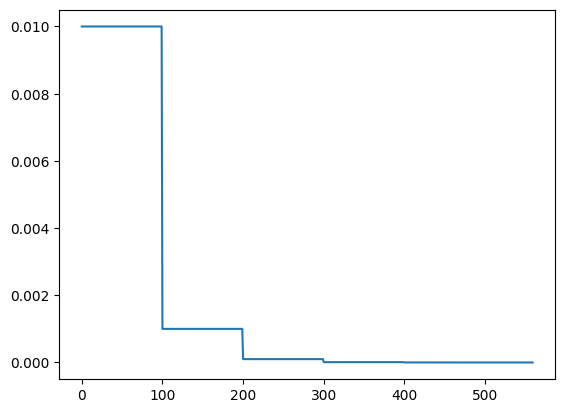

In [51]:
plt.plot([i for i in range(len(history["lr"]))], history["lr"])

In [55]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

NameError: name 'plt' is not defined

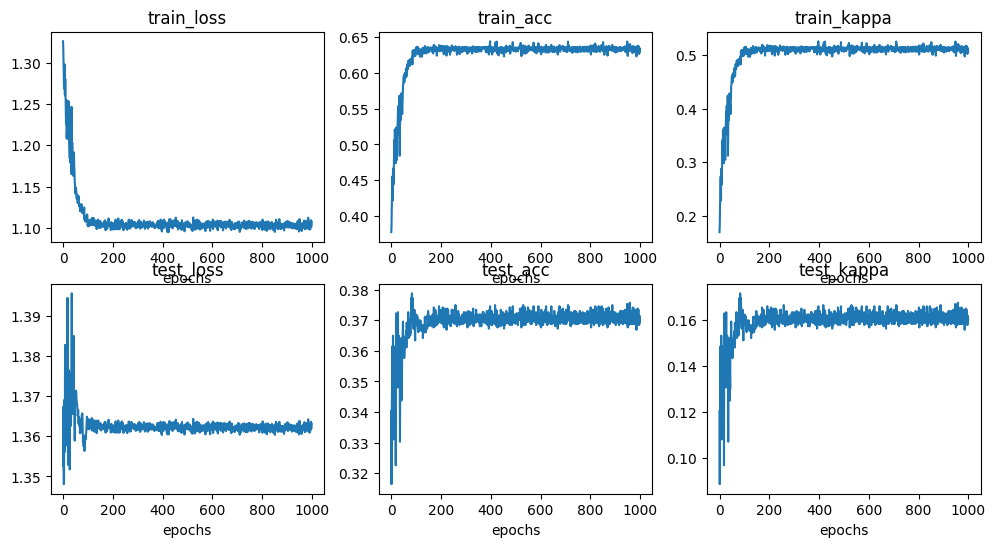

In [90]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))

for i, title in enumerate(
    [
        "train_loss",
        "train_acc",
        "train_kappa",
        "test_loss",
        "test_acc",
        "test_kappa",
    ]
):
    axs[i // 3, i % 3].plot([i for i in range(len(history[title]))], history[title])
    axs[i // 3, i % 3].set_title(title)

for ax in axs.flat:
    ax.set(xlabel="epochs", ylabel="")

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

In [36]:
a = 0.3549382716049383
print(f"{a:.2}")

0.35
